In [2]:
import keras
from keras import backend as K
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from IPython.display import display

import os, sys

Using TensorFlow backend.


In [35]:
def grab_image(img_path):
    #path = dirs+'/'+img_path
    img = image.load_img(img_path, target_size=(100, 100))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

# Load image data
#imgdat_glass = np.concatenate([grab_image('./TrashNet-Dataset/%d.jpg'%(i) for i in range(356))])
imgdat_glass = np.concatenate([grab_image('./TrashNet-Dataset/%d.jpg'%(i)) for i in range(356)])
imgdat_plastic = np.concatenate([grab_image('./TrashNet-Dataset/%d.jpg'%(i)) for i in range(356,627)])
imgdat_cardboard = np.concatenate([grab_image('./TrashNet-Dataset/%d.jpg'%(i)) for i in range(627,976)])
imgdat_can = np.concatenate([grab_image('./TrashNet-Dataset/%d.jpg'%(i)) for i in range(976,1333)])
#imgdat_plastic = np.load('TrashNet-Dataset/%d.jpg'%(i) for i in range(356,627))
#imgdat_cardboard = np.load('TrashNet-Dataset/%d.jpg'%(i) for i in range(627,976))
#imgdat_can = np.load('TrashNet-Dataset/%d.jpg'%(i) for i in range(976,1333))

# Make sure the data loaded correctly
print(imgdat_glass.shape)
print(imgdat_plastic.shape)
print(imgdat_cardboard.shape)
print(imgdat_can.shape)                           
                           
#x_train = np.concatenate([grab_image('./TrashNet-Dataset/%d.jpg'%(i)) for i in range(1333)])
#x_train = x_train.astype('float32').reshape(x_train.shape)
#x_train /= 100
#x_train.shape

(356, 100, 100, 3)
(271, 100, 100, 3)
(349, 100, 100, 3)
(357, 100, 100, 3)


In [56]:
with open('labels.csv', 'r', encoding = 'utf-8-sig') as f:
    labels = f.read().split(',')
Y = keras.utils.to_categorical(labels)
Y.shape

(1333, 4)

In [38]:
# Concatenate image data for input to network
#X = np.concatenate((imgdat_glass, imgdat_paper, imgdat_cardboard, 
#                   imgdat_plastic, imgdat_metal, imgdat_trash))


# Split labels up by category
imgdat_lens = [imgdat_glass.shape[0], imgdat_plastic.shape[0], imgdat_cardboard.shape[0],
               imgdat_can.shape[0]]
Y_categories = []
index_start = 0
for imgdat_len in imgdat_lens:
    index_end = index_start + imgdat_len
    Y_categories = Y_categories + [Y[index_start : index_end]]
    index_start = index_end

# Shuffle all image data
imgdat_glass = imgdat_glass[np.random.permutation(len(imgdat_glass))]
imgdat_plastic = imgdat_plastic[np.random.permutation(len(imgdat_plastic))]
imgdat_cardboard = imgdat_cardboard[np.random.permutation(len(imgdat_cardboard))]
imgdat_can = imgdat_can[np.random.permutation(len(imgdat_can))]

# Split image categories into training and testing sets
def getHalfLen(img_set):
    return int(len(img_set) / 2)

training_glass = imgdat_glass[ : getHalfLen(imgdat_glass)]
training_glass_labels = Y_categories[0][ : getHalfLen(Y_categories[0])]
training_plastic = imgdat_plastic[ : getHalfLen(imgdat_plastic)]
training_plastic_labels = Y_categories[1][ : getHalfLen(Y_categories[1])]
training_cardboard = imgdat_cardboard[ : getHalfLen(imgdat_cardboard)]
training_cardboard_labels = Y_categories[2][ : getHalfLen(Y_categories[2])]
training_can = imgdat_can[ : getHalfLen(imgdat_can)]
training_can_labels = Y_categories[3][ : getHalfLen(Y_categories[3])]

testing_glass = imgdat_glass[getHalfLen(imgdat_glass) : ]
testing_glass_labels = Y_categories[0][getHalfLen(Y_categories[0]) : ]
testing_plastic = imgdat_plastic[getHalfLen(imgdat_plastic) : ]
testing_plastic_labels = Y_categories[1][getHalfLen(Y_categories[1]) : ]
testing_cardboard = imgdat_cardboard[getHalfLen(imgdat_cardboard) : ]
testing_cardboard_labels = Y_categories[2][getHalfLen(Y_categories[2]) : ]
testing_can = imgdat_can[getHalfLen(imgdat_can) : ]
testing_can_labels = Y_categories[3][getHalfLen(Y_categories[3]) : ]

# Concatenate into training and testing sets
X_train = np.concatenate((training_glass, training_plastic, training_cardboard,
                          training_can))
Y_train = np.concatenate((training_glass_labels, training_plastic_labels, training_cardboard_labels,
                          training_can_labels))

X_test = np.concatenate((testing_glass, testing_plastic, testing_cardboard,
                         testing_can))
Y_test = np.concatenate((testing_glass_labels, testing_plastic_labels, testing_cardboard_labels,
                         testing_can_labels))

# Shuffle training and testing sets
permute = np.random.permutation(len(X_train))
X_train = X_train[permute]
Y_train = Y_train[permute]

permute = np.random.permutation(len(X_test))
X_test = X_test[permute]
Y_test = Y_test[permute]

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)
print('Combined X: ', X_train.shape[0] + X_test.shape[0])

X_train shape:  (665, 100, 100, 3)
Y_train shape:  (665, 4)
X_test shape:  (668, 100, 100, 3)
Y_test shape:  (668, 4)
Combined X:  1333


In [42]:
# Mean-center all image data
#X = (X - X.mean()) / X.std()
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

In [48]:
# We'll shuffle these categories separately so that we can ensure both
# training and testing sets have some images from each category.
import random
# Concatenate image data for input to network
X = np.concatenate((imgdat_glass, imgdat_plastic, imgdat_cardboard, 
                   imgdat_can))

size = 100

imgdat_lens = [imgdat_glass.shape[0], imgdat_plastic.shape[0], imgdat_cardboard.shape[0],
               imgdat_can.shape[0]]
X_categories = []
Y_categories = []

index_start = 0
for imgdat_len in imgdat_lens:
    index_end = index_start + imgdat_len
    X_categories = X_categories + [X[index_start : index_end]]
    Y_categories = Y_categories + [Y[index_start : index_end]]
    index_start = index_end
    
X_train = np.array([])
X_test = np.array([])
Y_train = np.array([])
Y_test = np.array([])

X_train.shape = (0, size, size, 3)
X_test.shape = (0, size, size, 3)
Y_train.shape = (0, 4)
Y_test.shape = (0, 4)

# Shuffle both X and Y
for i in range(len(X_categories)):
    for j in range(X_categories[i].shape[0]):
        randIndex = random.randint(0, X_categories[i].shape[0] - 1)

        # Swap X
        tempX = X_categories[i][j]
        X_categories[i][j] = X_categories[i][randIndex]
        X_categories[i][randIndex] = tempX

        # Don't actually have to swap Y since we'd just be shuffling labels in each
        # category, meaning we'd have essentially the same arrangement we started with.
        # Swap Y
        #tempY = Y_categories[i][j]
        #Y_categories[i][j] = Y_categories[i][randIndex]
        #Y_categories[i][randIndex] = tempY
    
    # Split the shuffled categories equally into training and testing sets
    half = int(X_categories[i].shape[0] / 2)
    X_train = np.concatenate((X_train, X_categories[i][0 : half]))
    X_test = np.concatenate((X_test, X_categories[i][half : ]))
    Y_train = np.concatenate((Y_train, Y_categories[i][0 : half]))
    Y_test = np.concatenate((Y_test, Y_categories[i][half : ]))
    
print("X shape: " + str(X.shape))
print("Y shape: " + str(Y.shape))
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_train shape: " + str(Y_train.shape))
print("Y_test shape: " + str(Y_test.shape))
print("X_train + X_test size: " + str(X_train.shape[0] + X_test.shape[0]))
print("Y_train + Y_test size: " + str(Y_train.shape[0] + Y_test.shape[0]))

X shape: (1333, 100, 100, 3)
Y shape: (1333, 4)
X_train shape: (665, 100, 100, 3)
X_test shape: (668, 100, 100, 3)
Y_train shape: (665, 4)
Y_test shape: (668, 4)
X_train + X_test size: 1333
Y_train + Y_test size: 1333


In [60]:
model = keras.Sequential()

# Bottleneck to keep parameters low
model.add(keras.layers.Conv2D(24, kernel_size = (1, 1), # squeeze
                              activation = 'relu',
                              bias_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None),
                              kernel_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None),
                              input_shape = [100, 100, 3]))

model.add(keras.layers.Conv2D(24, kernel_size = (3, 3), # map 
                              strides = (2, 2),
                              activation = 'relu',
                              bias_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None),
                              kernel_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None)))

model.add(keras.layers.Conv2D(32, kernel_size = (1, 1), # expand
                             activation = 'relu',
                             bias_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None), 
                             kernel_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None)))
model.add(keras.layers.BatchNormalization(momentum = 0.99))

model.add(keras.layers.SpatialDropout2D(rate = 0.25))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))

model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(Y.shape[1] * 2, activation = 'tanh'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(Y.shape[1], activation = 'softmax'))

model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.0001, amsgrad = True),
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 100, 100, 24)      96        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 49, 49, 24)        5208      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 49, 49, 32)        800       
_________________________________________________________________
batch_normalization_5 (Batch (None, 49, 49, 32)        128       
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 49, 49, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 18432)             0         
__________

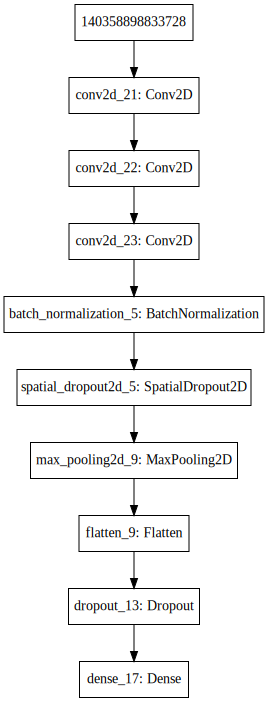

In [61]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog = 'dot', format = 'svg'))

In [62]:
from keras_tqdm import TQDMNotebookCallback
history = model.fit(X_train, Y_train, batch_size = 200, 
                    epochs = 10, verbose = 0, validation_split = 0.2)
print('Accuracy: ', model.evaluate(X_test, Y_test)[1] * 100.0, '%')

668/668 [==============================] - 2s 4ms/step
Accuracy:  61.52694611670728 %


In [64]:
history2 = model.fit(X_train, Y_train, batch_size = 200, 
                    epochs = 100, verbose = 0, validation_split = 0.25)
print('Accuracy: ', model.evaluate(X, Y)[1] * 100.0, '%')

1333/1333 [==============================] - 4s 3ms/step
Accuracy:  74.86871719047349 %


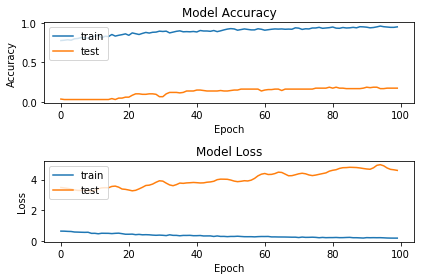

In [65]:
plt.figure(1)

# Accuracy
plt.subplot(211)
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')

# Loss
plt.subplot(212)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')

plt.tight_layout()
plt.show()

In [66]:
preds = model.predict(X_test)

[ 0.02941232  1.4564695   0.5148726  97.999245  ]
[0. 0. 0. 1.]


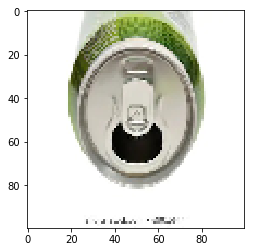

In [75]:
img = 500
np.set_printoptions(suppress = True)
print(preds[img] * 100.0)
print(Y_test[img])

plt.imshow(keras.preprocessing.image.array_to_img(X_test[img, :, :, :]))
plt.show()